# Prepare Dataset

In [ ]:
import os
import numpy as np
import cv2
import torch
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from albumentations import HorizontalFlip, VerticalFlip, Rotate


def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path, split=0.2):
    """ Load the images and masks """
    images = sorted(glob(f"{path}/*/image/*.png"))
    masks = sorted(glob(f"{path}/*/mask/*.png"))

    """ Split the data """
    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y)

def augment_data(images, masks, save_path, augment=True):
    """ Performing data augmentation. """
    H = 512
    W = 512

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the dir name and image name """
        dir_name = x.split("\\")[-3]
        name = dir_name + "_" + x.split("\\")[-1].split(".")[0]

        """ Read the image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            aug = Rotate(limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            X = [x, x1, x2, x3]
            Y = [y, y1, y2, y3]

        else:
            X = [x]
            #print(len(X))
            Y =[y]

        idx = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))
            m = m/255.0
            m = (m > 0.5) * 255

            if len(X) == 1:  # each loop it will take one image 
                tmp_image_name = f"{name}.jpg"
                tmp_mask_name  = f"{name}.jpg"
            else:
                tmp_image_name = f"{name}_{idx}.jpg"
                tmp_mask_name  = f"{name}_{idx}.jpg"

            image_path = os.path.join(save_path, "image/", tmp_image_name)
            mask_path  = os.path.join(save_path, "mask/", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1
        


if __name__ == "__main__":
    """ Load the dataset """
    dataset_path = os.path.join("data", "train")
    (train_x, train_y), (valid_x, valid_y) = load_data(dataset_path, split=0.2)

    print("Train: ", len(train_x))
    print("Valid: ", len(valid_x))

    create_dir("new_data/train/image/")
    create_dir("new_data/train/mask/")
    create_dir("new_data/val/image/")
    create_dir("new_data/val/mask/")

    augment_data(train_x, train_y, "new_data/train/", augment=True)
    augment_data(valid_x, valid_y, "new_data/val/", augment=False)

Train:  2026
Valid:  506


100%|██████████| 506/506 [00:08<00:00, 61.27it/s]


In [8]:
img = cv2.imread("F:\\final project\\CT Heart\\data\\train\\image\\100051_1-009_2.jpg")
print(img.shape)

(512, 512, 3)


In [16]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image

class CustomSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir)
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.image_names[idx])
        
        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Single channel for mask
        
        if self.transform:
            # Apply the same transform to both image and mask
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask


# Data transformations and dataloader

In [15]:
#change directory 
os.chdir(r'F:\\final project\\CT Heart')

# Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Dataset and DataLoader
image_dir = 'data\\train\\image'
mask_dir = 'data\\train\\mask'

train_dataset = CustomSegmentationDataset(image_dir, mask_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


# Visualize some images

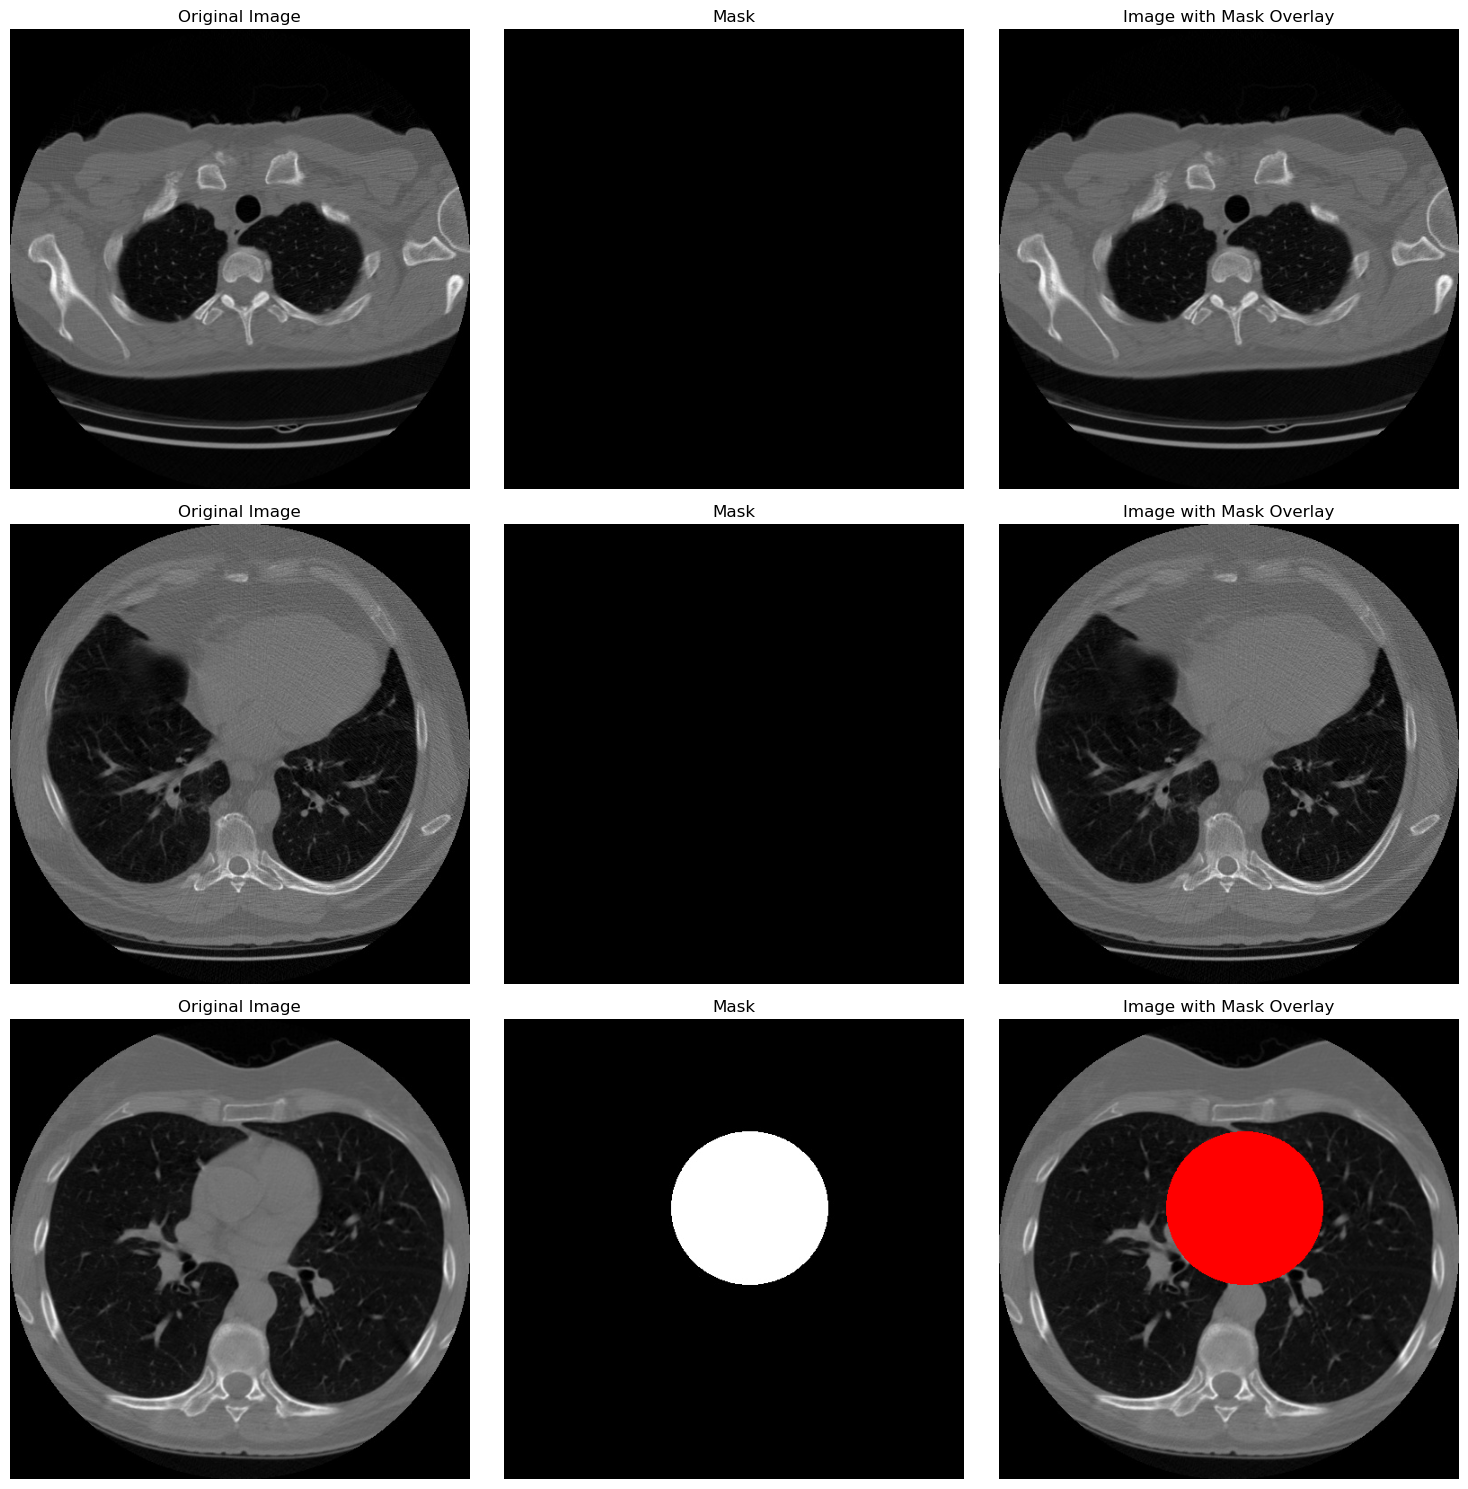

In [14]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

def visualize_images_with_masks(image_paths, mask_paths, num_samples=3):
    """ Visualize multiple images with their corresponding masks. """
    selected_indices = random.sample(range(len(image_paths)), num_samples)
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    for idx, sample_idx in enumerate(selected_indices):
        # Load the image and mask
        image = cv2.imread(image_paths[sample_idx], cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_paths[sample_idx], cv2.IMREAD_GRAYSCALE)
        
        # Convert the image from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Normalize mask to range [0, 1]
        mask = mask / 255.0
        
        # Create an overlay of the mask on the image
        overlay = image.copy()
        overlay[mask > 0.5] = [255, 0, 0]  # Red color for mask overlay
        
        # Plot the original image, mask, and overlay
        plt.subplot(num_samples, 3, idx * 3 + 1)
        plt.title("Original Image")
        plt.imshow(image)
        plt.axis("off")
        
        plt.subplot(num_samples, 3, idx * 3 + 2)
        plt.title("Mask")
        plt.imshow(mask, cmap='gray')
        plt.axis("off")
        
        plt.subplot(num_samples, 3, idx * 3 + 3)
        plt.title("Image with Mask Overlay")
        plt.imshow(overlay)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Specify paths to images and masks
    image_dir = "data/train/image/"
    mask_dir = "data/train/mask/"
    
    image_files = sorted(glob(f"{image_dir}/*.jpg"))
    mask_files = sorted(glob(f"{mask_dir}/*.jpg"))
    
    # Visualize 3 random image-mask pairs
    visualize_images_with_masks(image_files, mask_files, num_samples=3)

# Define the model

In [20]:
from segmentation_models_pytorch import Unet

# Define UNet model
model = Unet(
    encoder_name="resnet101",  
    encoder_weights="imagenet",
    in_channels=3,
    classes=1  
).cuda()

# Loss Function and Optimizer


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train the model

In [21]:
import warnings
warnings.filterwarnings("ignore", message="No positive class found in y_true")


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from tqdm import tqdm

def calculate_map(preds, masks):

    # Detach tensors, move to CPU, and flatten
    preds_flat = preds.detach().view(-1).cpu().numpy()
    masks_flat = masks.detach().view(-1).cpu().numpy()
    
    # Ensure masks are binary
    masks_flat = (masks_flat > 0.5).astype(int)
    
    # Compute precision-recall curve and average precision
    precision, recall, _ = precision_recall_curve(masks_flat, preds_flat)
    ap = average_precision_score(masks_flat, preds_flat)
    
    return ap



# Training loop
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    total_ap = 0
    total_batches = 0
    
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Convert predictions to probabilities
        preds = torch.sigmoid(outputs)  # Apply sigmoid for binary segmentation
        
        # Calculate mAP
        ap = calculate_map(preds, masks)
        total_ap += ap
        total_batches += 1
    
    # Calculate average metrics for the epoch
    avg_loss = epoch_loss / total_batches
    avg_map = total_ap / total_batches
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, mAP: {avg_map:.4f}")




Epoch 1/10:   0%|          | 0/1013 [00:00<?, ?batch/s]

Epoch 1/10: 100%|██████████| 1013/1013 [03:22<00:00,  5.01batch/s]


Epoch 1/10, Loss: 0.0151, mAP: 0.9504


Epoch 2/10: 100%|██████████| 1013/1013 [03:06<00:00,  5.44batch/s]


Epoch 2/10, Loss: 0.0142, mAP: 0.9534


Epoch 3/10: 100%|██████████| 1013/1013 [03:07<00:00,  5.41batch/s]


Epoch 3/10, Loss: 0.0140, mAP: 0.9459


Epoch 4/10: 100%|██████████| 1013/1013 [03:06<00:00,  5.42batch/s]


Epoch 4/10, Loss: 0.0120, mAP: 0.9549


Epoch 5/10: 100%|██████████| 1013/1013 [03:07<00:00,  5.42batch/s]


Epoch 5/10, Loss: 0.0117, mAP: 0.9594


Epoch 6/10: 100%|██████████| 1013/1013 [03:07<00:00,  5.40batch/s]


Epoch 6/10, Loss: 0.0107, mAP: 0.9687


Epoch 7/10: 100%|██████████| 1013/1013 [03:09<00:00,  5.35batch/s]


Epoch 7/10, Loss: 0.0108, mAP: 0.9550


Epoch 8/10: 100%|██████████| 1013/1013 [03:08<00:00,  5.38batch/s]


Epoch 8/10, Loss: 0.0099, mAP: 0.9576


Epoch 9/10: 100%|██████████| 1013/1013 [03:07<00:00,  5.41batch/s]


Epoch 9/10, Loss: 0.0104, mAP: 0.9564


Epoch 10/10: 100%|██████████| 1013/1013 [03:07<00:00,  5.41batch/s]

Epoch 10/10, Loss: 0.0099, mAP: 0.9599


# save the model

In [25]:
torch.save(model.state_dict(), 'unet_model')

# Validate the Model


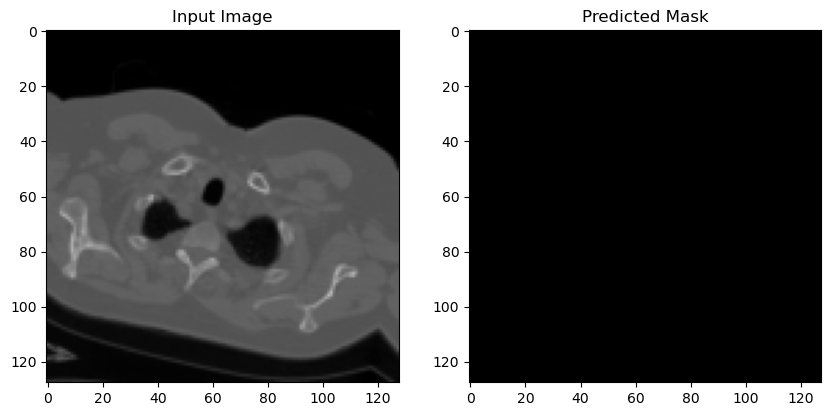

In [26]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5  # Threshold for binary masks
        
        # Visualize
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Input Image')
        plt.imshow(images[0].cpu().permute(1, 2, 0))
        plt.subplot(1, 2, 2)
        plt.title('Predicted Mask')
        plt.imshow(preds[0].cpu().squeeze(), cmap='gray')
        plt.show()
        break


# load the model

In [23]:
import os
import torch
from tqdm import tqdm
os.chdir(r'F:\\final project\\CT Heart')

model.load_state_dict(torch.load('unet_model'))

C:\Users\Ahmed Amr\AppData\Local\Temp\ipykernel_3448\1252159304.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('unet_model'))


<All keys matched successfully>

In [17]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Dataset and DataLoader
image_dir = 'data\\val\\image'
mask_dir = 'data\\val\\mask'

test_dataset = CustomSegmentationDataset(image_dir, mask_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [24]:
def validate_model(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Disable gradient computation
        for images, masks in tqdm(dataloader, desc="Validation"):
            # Move data to the device (GPU or CPU)
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass: Get predictions
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            
            # Apply sigmoid to outputs for binary classification
            preds = torch.sigmoid(outputs)
            
            # Threshold predictions (binary classification: 0 or 1)
            preds = (preds > 0.5).float()
            
            # Store predictions and true masks for metric calculation
            all_preds.append(preds.cpu())
            all_targets.append(masks.cpu())
    
    # Concatenate all predictions and targets
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    # Calculate metrics
    dice_score = dice_metric(all_preds, all_targets)
    iou_score = iou_metric(all_preds, all_targets)
    
    # Return average loss and metrics
    avg_loss = total_loss / len(dataloader)
    return avg_loss, dice_score, iou_score

def dice_metric(preds, targets):
    smooth = 1e-6
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.item()

def iou_metric(preds, targets):
    smooth = 1e-6
    intersection = (preds * targets).sum()
    union = (preds + targets - preds * targets).sum()
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

# Example usage
if __name__ == "__main__":
    # Assume test_loader is a DataLoader for the test dataset
    # Assume model is already trained and loaded
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = torch.nn.BCEWithLogitsLoss()
    
    avg_loss, dice, iou = validate_model(model, test_loader, criterion, device)
    print(f"Validation Loss: {avg_loss:.4f}, Dice Score: {dice:.4f}, IoU: {iou:.4f}")

Validation: 100%|██████████| 64/64 [02:17<00:00,  2.14s/it]

Validation Loss: 0.0096, Dice Score: 0.9397, IoU: 0.8862


# inference model

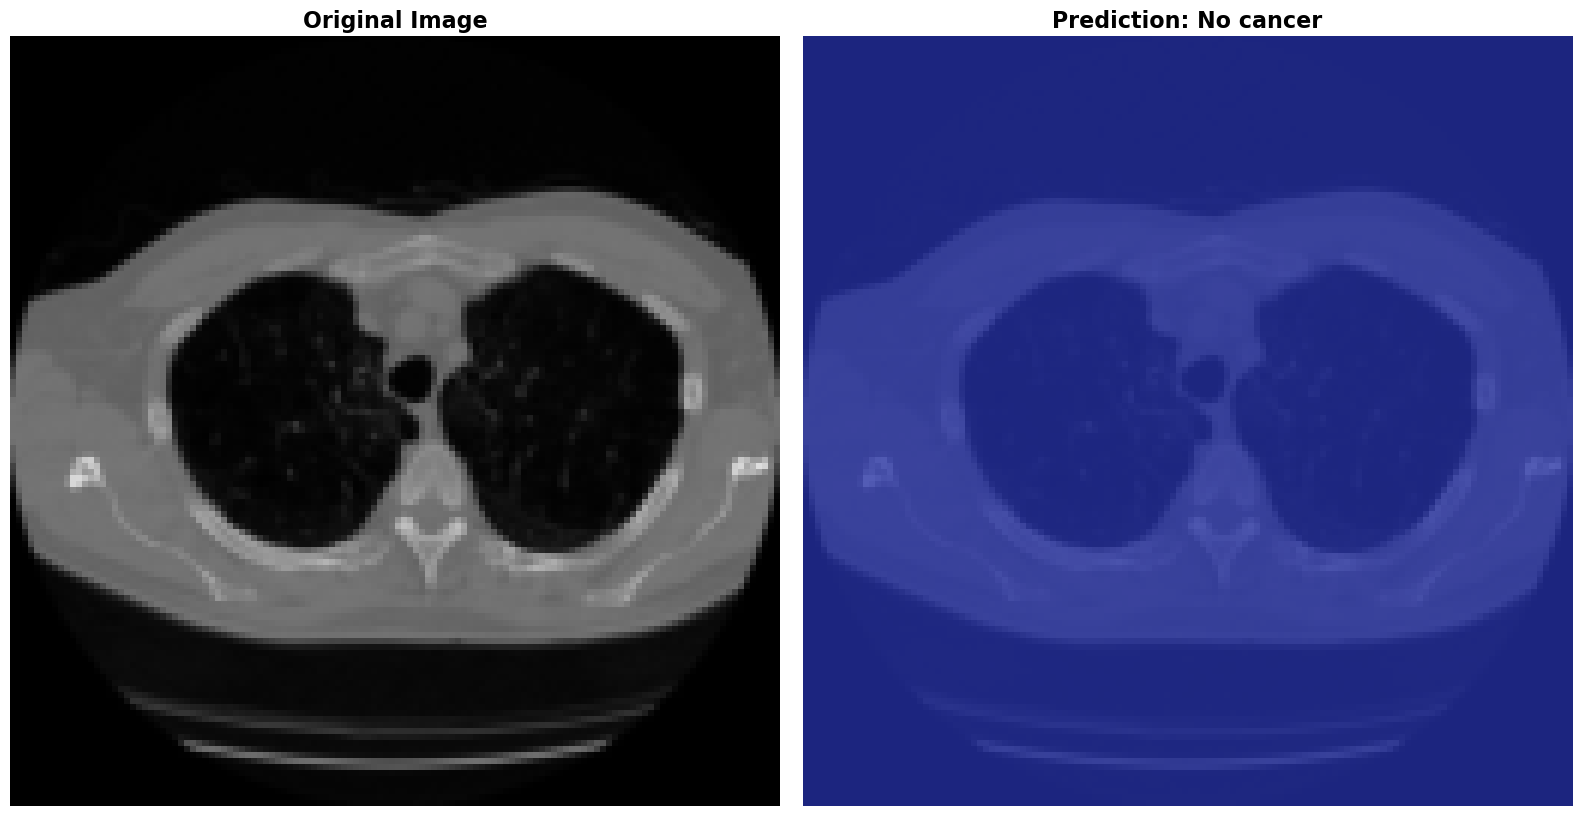

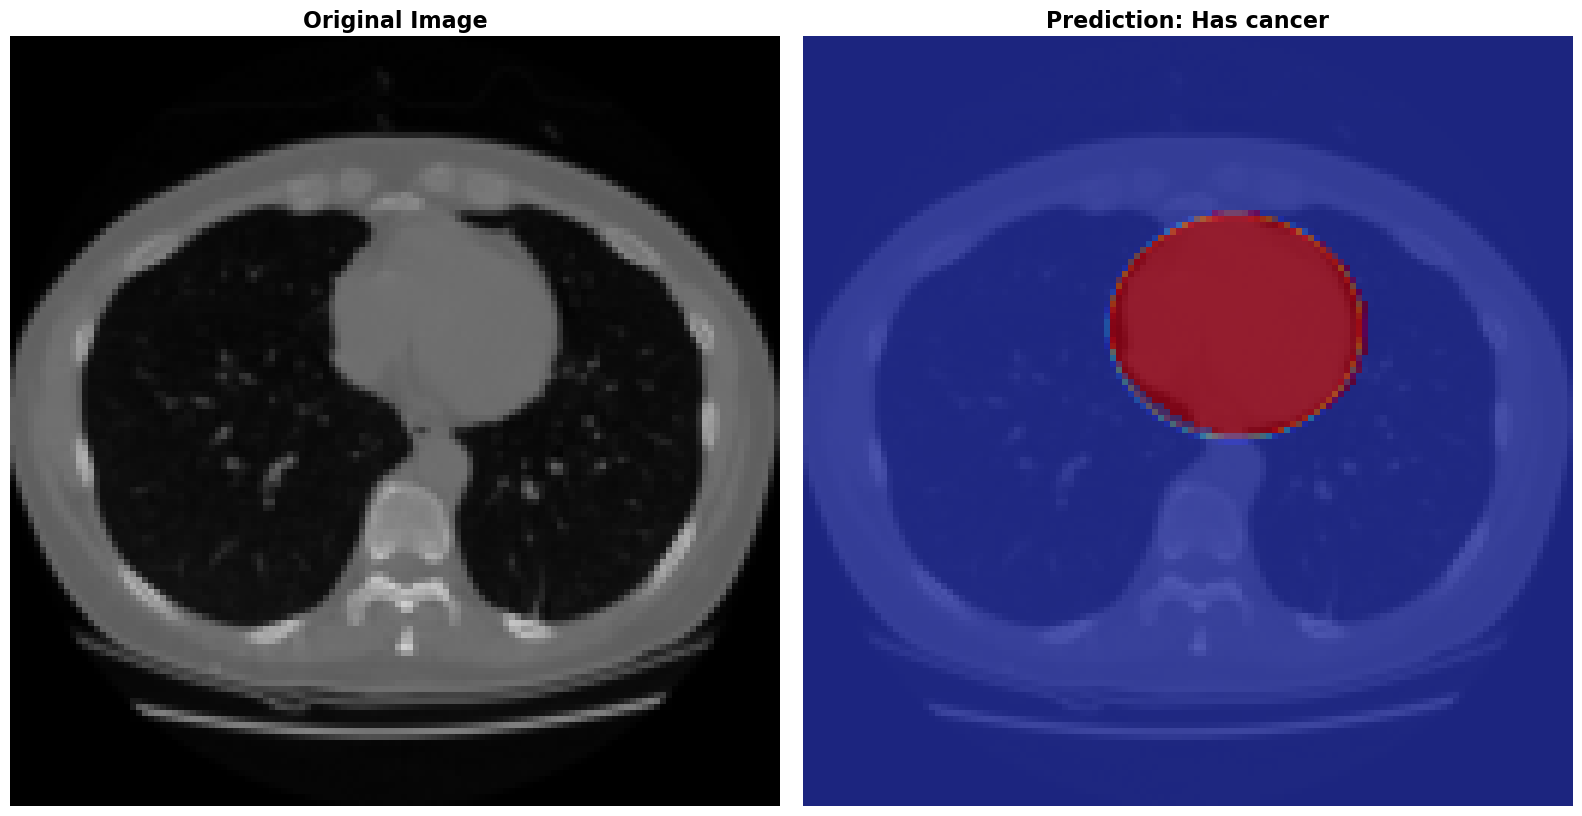

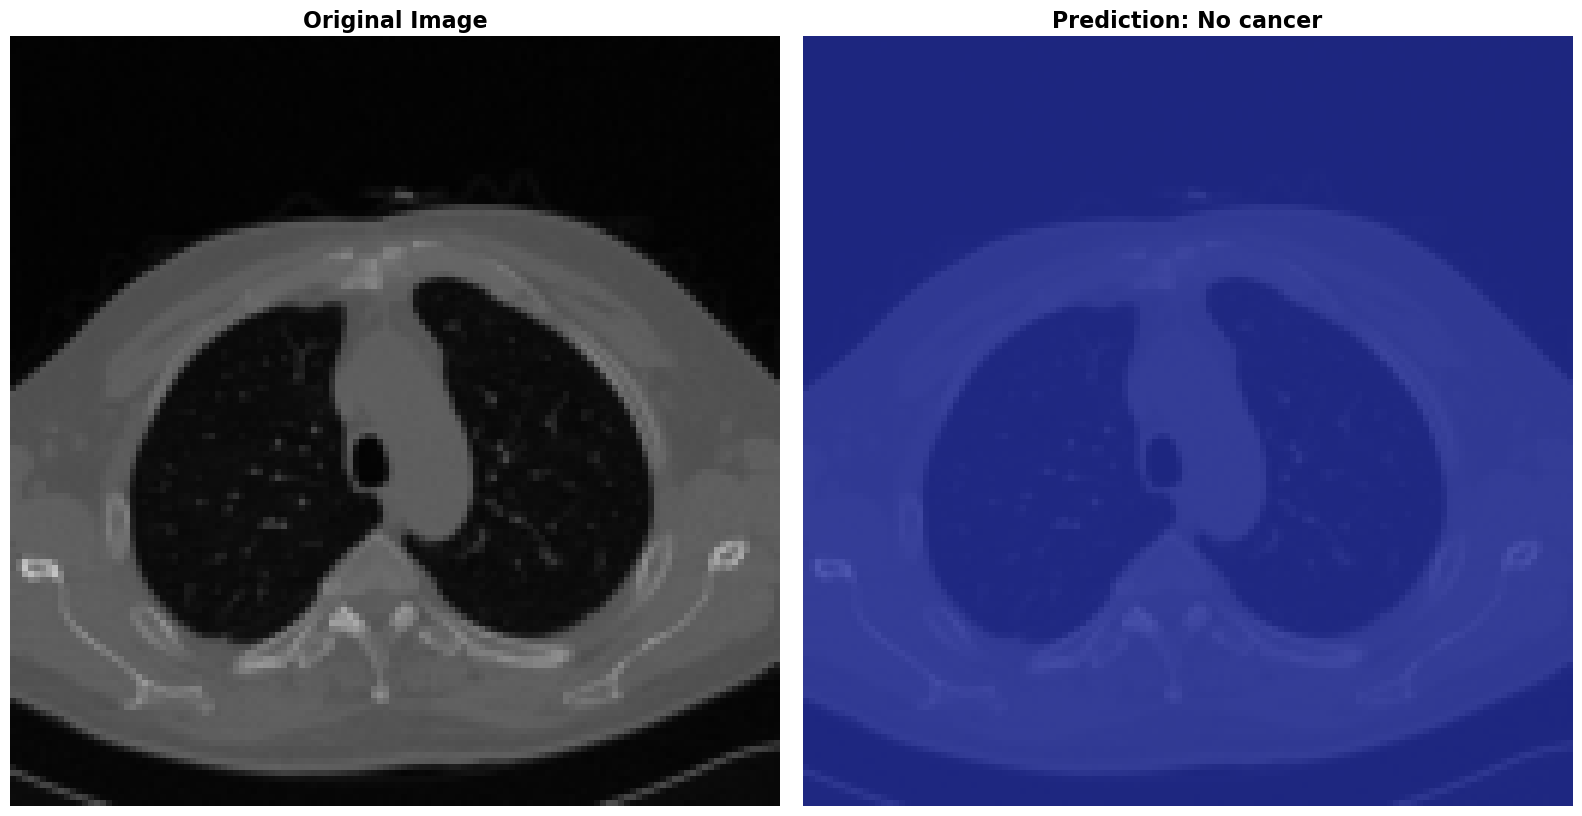

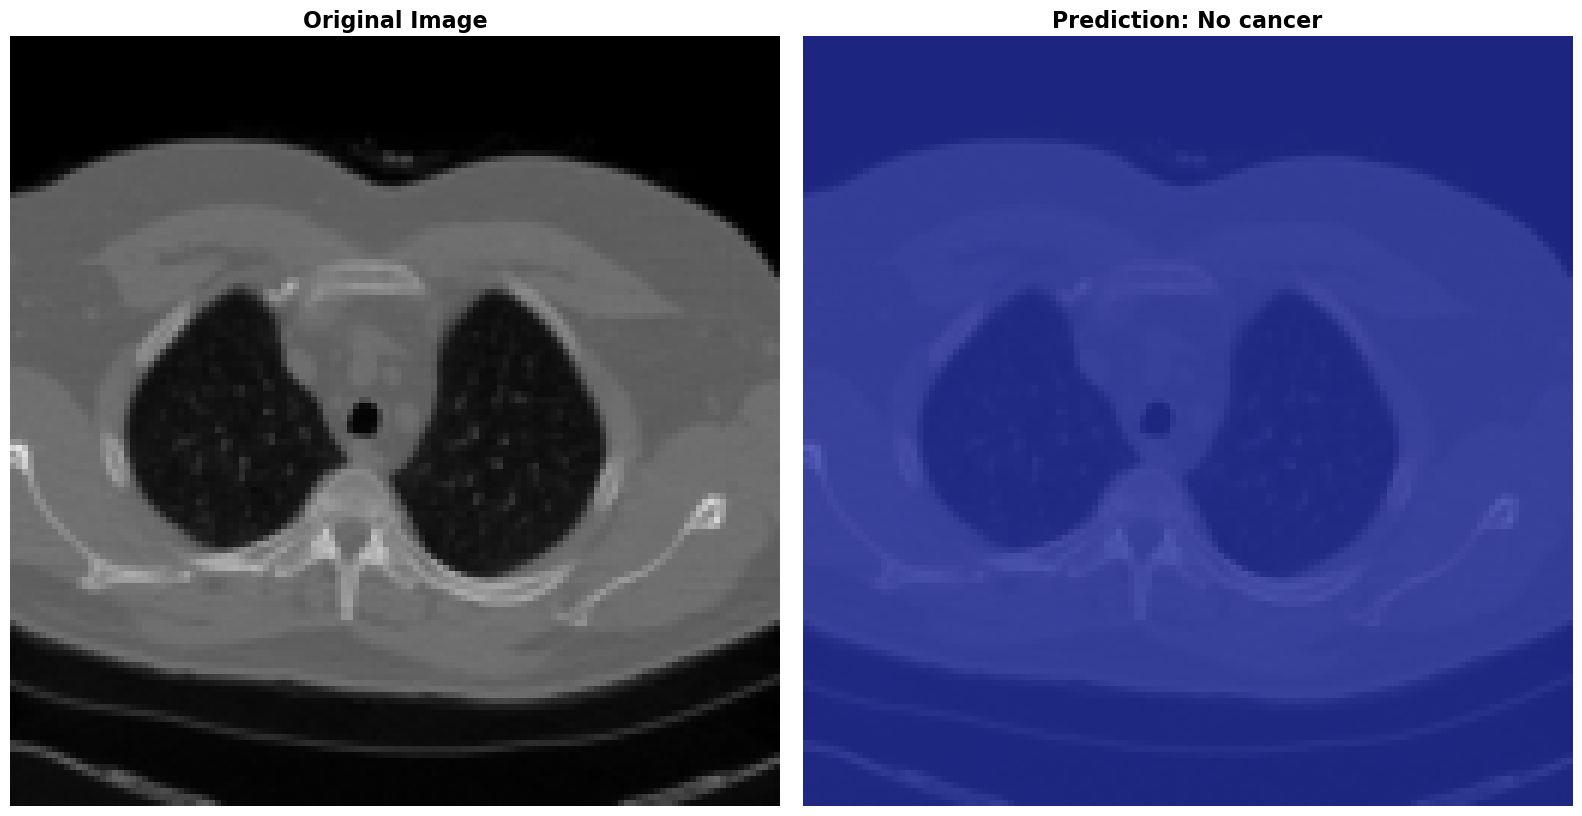

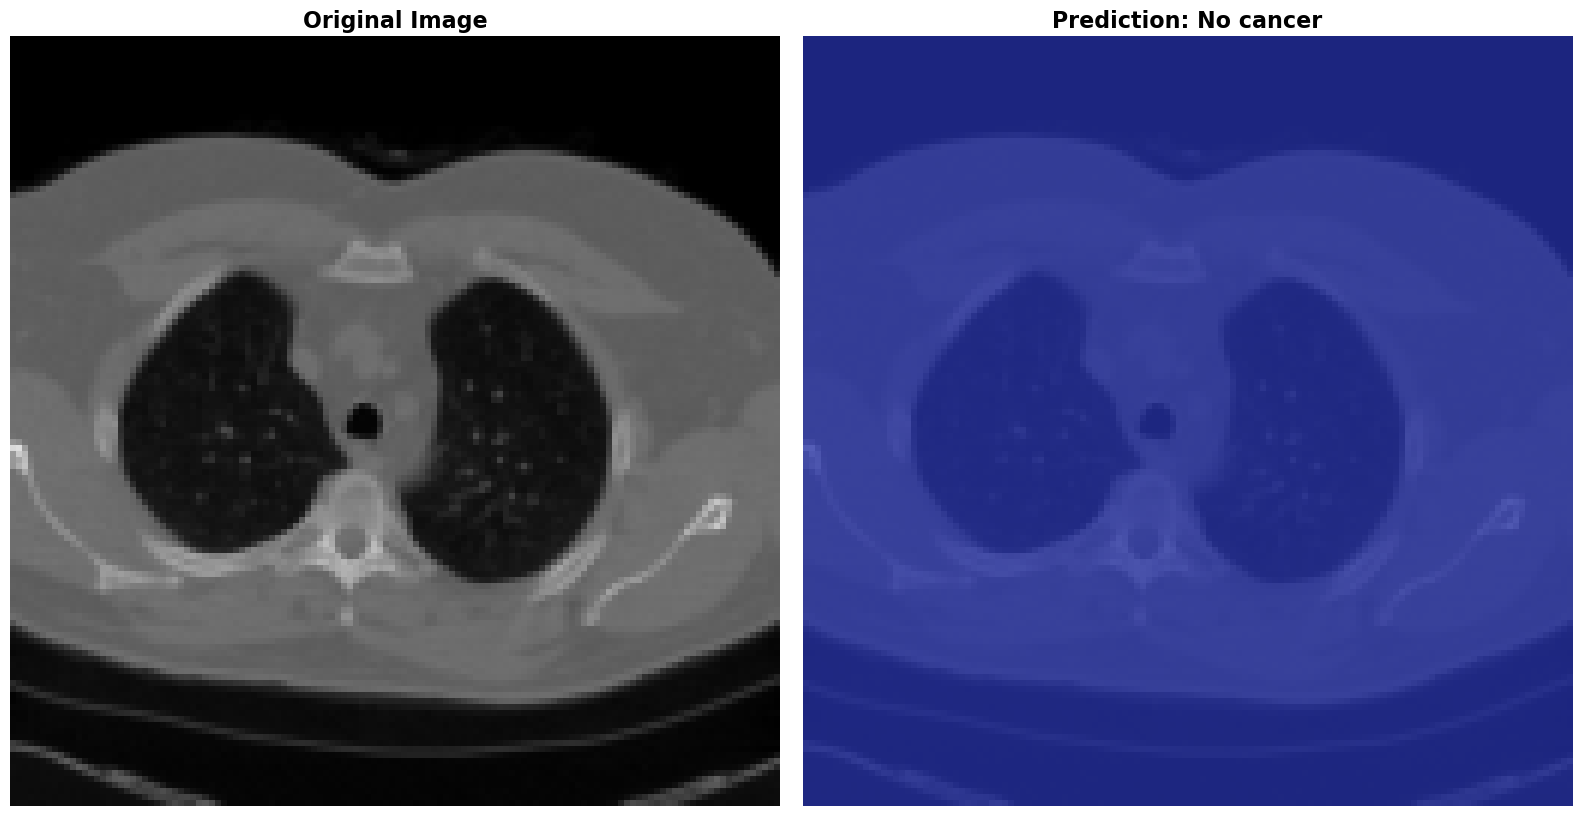

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_image_with_mask_and_title(image, mask, pred_mask):
    # Convert tensors to NumPy arrays if needed
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()  # [C, H, W] -> [H, W, C]
    if isinstance(mask, torch.Tensor):
        mask = mask.squeeze(0).cpu().numpy()  # [1, H, W] -> [H, W]
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.squeeze(0).cpu().numpy()  # [1, H, W] -> [H, W]

    # Normalize image for visualization if needed (scale to [0, 1])
    if image.max() > 1.0:
        image = image / 255.0

    # Check for the presence of cancer in the mask (if mask has non-zero pixels, it's "Has cancer")
    has_cancer = np.sum(mask) > 0  # If any pixel is 1 in the mask, it means "Has cancer"
    title = "Has cancer" if has_cancer else "No cancer"

    # Create a figure with two subplots (original image and masked image)
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image in the first subplot
    axes[0].imshow(image)
    axes[0].set_title("Original Image", fontsize=16, color="black", weight='bold')
    axes[0].axis("off")  # Hide axes

    # Plot the original image in the second subplot with mask overlays
    axes[1].imshow(image)
    axes[1].imshow(mask, cmap="jet", alpha=0.5)  # Overlay ground truth mask
    axes[1].imshow(pred_mask, cmap="coolwarm", alpha=0.5)  # Overlay predicted mask
    axes[1].set_title(f"Prediction: {title}", fontsize=16, color="black", weight='bold')
    axes[1].axis("off")  # Hide axes

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage with the batch of images
with torch.no_grad():
    i=0
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        preds = model(images)  # Forward pass
        preds_binary = (torch.sigmoid(preds) > 0.5).float()  # Convert to binary mask              
        
        # Show the first image in the batch with mask overlays
        show_image_with_mask_and_title(images[0], masks[0], preds_binary[0])  # Show the first image from the batch
        
        i += 1
        if i == 5:
            break


In [9]:
import os
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import cv2

def eval_model(model, dataloader, device, metrics, save_results_dir=None):

    model.eval()
    metric_scores = {name: [] for name in metrics.keys()}

    if save_results_dir:
        os.makedirs(save_results_dir, exist_ok=True)

    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(dataloader, desc="Evaluating")):
            # Move inputs to device
            images = images.to(device)
            masks = masks.to(device)  # Assuming masks are in (B, H, W) format

            # Predict
            logits = model(images)
            preds = torch.sigmoid(logits) > 0.5  # Binarize predictions for binary segmentation

            # Convert tensors to numpy
            masks_np = masks.cpu().numpy().astype(np.int32).flatten()
            preds_np = preds.cpu().numpy().astype(np.int32).flatten()

            # Calculate metrics
            for name, metric_fn in metrics.items():
                score = metric_fn(masks_np, preds_np)
                metric_scores[name].append(score)

    # Calculate average metrics
    avg_metrics = {name: np.mean(scores) for name, scores in metric_scores.items()}
    return avg_metrics


In [10]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
from segmentation_models_pytorch import Unet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
# Define your model, test dataset, and DataLoader
model = Unet(encoder_name="resnet101", encoder_weights="imagenet", in_channels=3, classes=1)
model.load_state_dict(torch.load('F:\\final project\\CT Heart\\unet_model'))
model = model.to(device)
image_dir = 'data\\val\\image'
mask_dir = 'data\\val\\mask'

test_dataset = CustomSegmentationDataset(image_dir, mask_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Metrics
metrics = {
    'accuracy': accuracy_score,
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average="binary", zero_division=1),
    'jaccard': lambda y_true, y_pred: jaccard_score(y_true, y_pred, average="binary", zero_division=1),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average="binary", zero_division=1),
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average="binary", zero_division=1),
}

# Evaluate
results = eval_model(model, test_loader, device, metrics, save_results_dir="results")
print("Evaluation Results:", results)


C:\Users\Ahmed Amr\AppData\Local\Temp\ipykernel_26972\3634498943.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('F:\\final project\\CT

Evaluation Results: {'accuracy': 0.9953407049179077, 'f1': 0.9359797406470218, 'jaccard': 0.8862697017297998, 'recall': 0.9799997930777453, 'precision': 0.9019704455212918}


In [17]:
import os
import numpy as np
import cv2
import torch
from segmentation_models_pytorch import Unet

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

if __name__ == "__main__":
    """ Seeding """
    torch.manual_seed(42)
    np.random.seed(42)

    """ Directory for storing results """
    create_dir("test")

    """ Loading the model """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Unet(encoder_name="resnet101", encoder_weights=None, in_channels=3, classes=1)
    model.load_state_dict(torch.load('F:\\final project\\CT Heart\\unet_model',map_location=device,weights_only=True))
    model = model.to(device)
    model.eval()

    """ Load the image """
    image_path = "F:\\final project\\CT Heart\\data\\train\\image\\100053_1-025_1.jpg"
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read the image (H, W, C)
    original_image = image.copy()  # Keep a copy of the original image for saving results

    """ Preprocess the image """
    image = cv2.resize(image, (128, 128))  # Resize to match the model's input size
    image = image / 255.0  # Normalize to [0, 1]
    image = np.transpose(image, (2, 0, 1))  # Change shape to (C, H, W)
    image = np.expand_dims(image, axis=0)  # Add batch dimension (B, C, H, W)
    image_tensor = torch.tensor(image, dtype=torch.float32).to(device)

    """ Predict the mask """
    with torch.no_grad():
        logits = model(image_tensor)  # Get model output
        preds = torch.sigmoid(logits)  # Apply sigmoid activation
        preds = preds > 0.5  # Threshold to binary mask
        preds = preds.cpu().numpy().squeeze().astype(np.uint8) * 255  # Convert to uint8 mask

    """ Cancer or No Cancer Decision """
    has_cancer = np.any(preds > 0)  # Check if the mask contains any non-zero pixels
    diagnosis = "Cancer" if has_cancer else "No Cancer"
    print(f"Diagnosis: {diagnosis}")

    """ Save the result """
    preds_resized = cv2.resize(preds, (original_image.shape[1], original_image.shape[0]))  # Resize mask back to original size
    result = np.concatenate([original_image, cv2.cvtColor(preds_resized, cv2.COLOR_GRAY2BGR)], axis=1)  # Concatenate original and mask

    """ Add Text Overlay """
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (0, 255, 0) if diagnosis == "No Cancer" else (0, 0, 255)  # Green for No Cancer, Red for Cancer
    thickness = 2
    position = (10, 50)  # Position to place the text

    cv2.putText(result, f"Diagnosis: {diagnosis}", position, font, font_scale, font_color, thickness, cv2.LINE_AA)

    save_path = "F:\\result.png"
    cv2.imwrite(save_path, result)

    print(f"Result saved at {save_path}")


Diagnosis: Cancer
Result saved at F:\result.png
